In [1]:
import torch
import torchvision
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tqdm
import torch.nn as nn

from skimage import exposure
import glob

import random

In [4]:
images = glob.glob('../data/chest_xray/train/*/*.jpeg')

In [5]:
images[0:10]

['../data/chest_xray/train/PNEUMONIA/person1262_bacteria_3220.jpeg',
 '../data/chest_xray/train/PNEUMONIA/person383_bacteria_1747.jpeg',
 '../data/chest_xray/train/PNEUMONIA/person763_virus_1391.jpeg',
 '../data/chest_xray/train/PNEUMONIA/person362_bacteria_1652.jpeg',
 '../data/chest_xray/train/PNEUMONIA/person1514_virus_2633.jpeg',
 '../data/chest_xray/train/PNEUMONIA/person378_virus_761.jpeg',
 '../data/chest_xray/train/PNEUMONIA/person37_bacteria_189.jpeg',
 '../data/chest_xray/train/PNEUMONIA/person780_virus_1411.jpeg',
 '../data/chest_xray/train/PNEUMONIA/person496_virus_1003.jpeg',
 '../data/chest_xray/train/PNEUMONIA/person1209_bacteria_3161.jpeg']

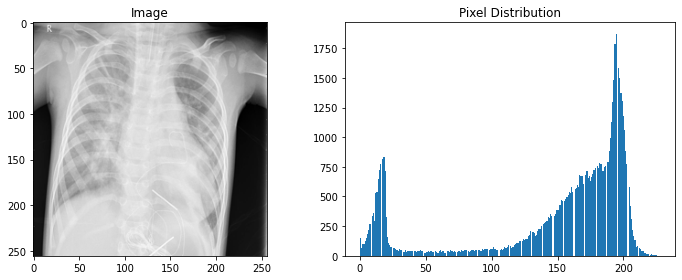

In [6]:
for each in images[0:10]:
    img = Image.open(each).resize((256, 256))
    img = np.array(img)
    
    # Create figure and subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # Plot image
    axes[0].imshow(img, cmap="gray")
    axes[0].set_title('Image')

    # Plot histogram
    axes[1].hist(img.ravel(), bins=256)
    axes[1].set_title('Pixel Distribution')

    # Adjust spacing between subplots
    plt.tight_layout()
    
    break

(256, 256)


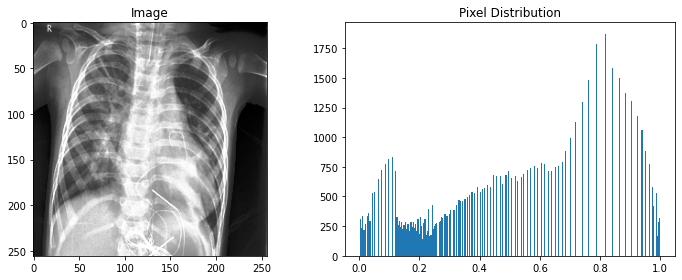

In [7]:
for each in images[0:10]:
    img = Image.open(each).convert("L").resize((256, 256))
    img = np.array(img)
    
    print(img.shape)
    
    img = exposure.equalize_hist(img)
    
    # Create figure and subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # Plot image
    axes[0].imshow(img, cmap="gray")
    axes[0].set_title('Image')

    # Plot histogram
    axes[1].hist(img.ravel(), bins=256)
    axes[1].set_title('Pixel Distribution')

    # Adjust spacing between subplots
    plt.tight_layout()
    
    break

In [ ]:
LABEL_ENCODING = {
    'NORMAL': 0,
    'PNEUMONIA': 1
}

class CXR_Dataset(torch.utils.data.Dataset):
    """
        Class for loading the images and their corresponding labels.
        Parameters:
        image_path (python list): A list contsisting of all the image paths (Normal and Pneunomina combined)
        transform (callable): Data augmentation pipeline.
    """
    def __init__(
        self,
        image_paths,
        transforms=None,
    ):
        super().__init__()
        self.image_paths = image_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):
        try:
            # Reading the image path and the corresponding label
            img_path = self.image_paths[item]
            label = self.image_paths[item].split('/')[-2] # Splitting the string and extracting the labels (the directory name in our case)
            label = torch.tensor(LABEL_ENCODING[label])
            # Opening the image using Pillow and resizing it to the required size
            img = Image.open(img_path).convert("L").resize((IMAGE_HEIGHT, IMAGE_WIDTH))
            img = np.array(img)
            
            # performing Histogram equalization on the Image to utilize the entire pixel range
            img = exposure.equalize_hist(img)
            
            img = (((img - img.min()) / img.max() - img.min())*255).astype(np.uint8) 
            
            # Stack the Gray scaled 1 channel image 3 times to convert to 3 channel image
            img = np.stack((img, )*3) 
            img = np.transpose(img, (1, 2, 0))
            
            # Performing data augmentation using the transforms pipeline
            img = self.transforms(img)
            return {"img": img, "target": label}

        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None

In [ ]:
IMAGE_HEIGHT = IMAGE_WIDTH = 256
ROTATION_RANGE = 30

In [ ]:
# Transform pipeline for data augmentation
transforms = torchvision.transforms.Compose([
                    torchvision.transforms.ToPILImage(),
                    torchvision.transforms.Resize((IMAGE_HEIGHT + 30, IMAGE_WIDTH + 30)),
                    torchvision.transforms.RandomCrop(size=(IMAGE_HEIGHT, IMAGE_WIDTH)),
                    torchvision.transforms.RandomRotation(degrees=ROTATION_RANGE),
                    torchvision.transforms.RandomHorizontalFlip(),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Change this according to the model weights. the mentioned mean and std are for ImageNet
            ])

In [88]:
dataset = CXR_Dataset(random.choices(images, k=32), transforms)

In [89]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size = 8,
    num_workers = 4,
    pin_memory=True,
    shuffle=True,
)

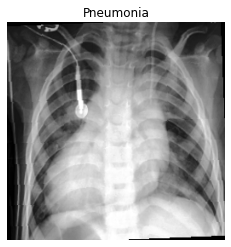

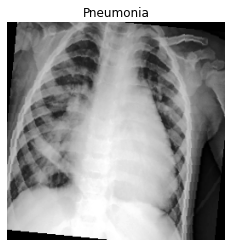

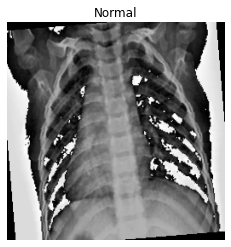

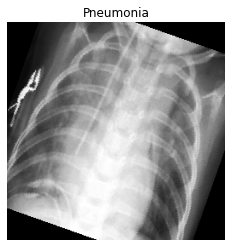

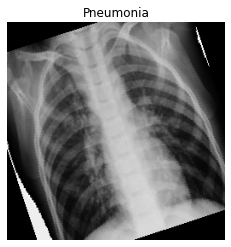

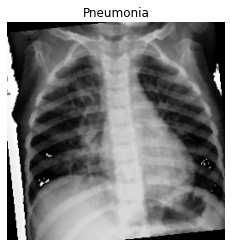

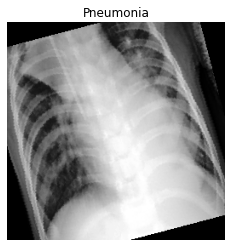

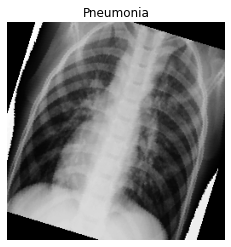

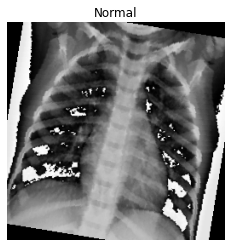

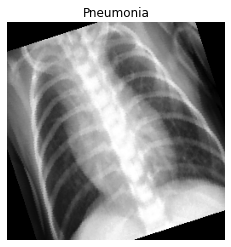

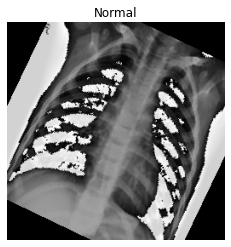

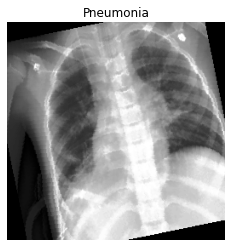

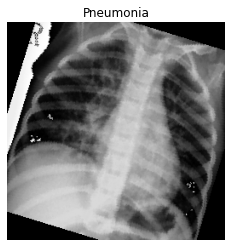

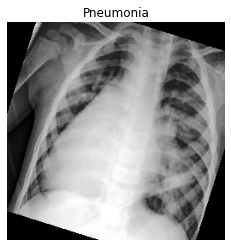

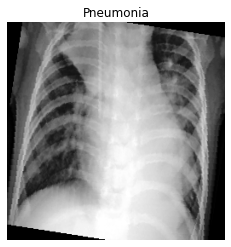

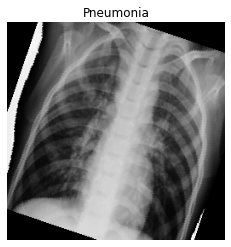

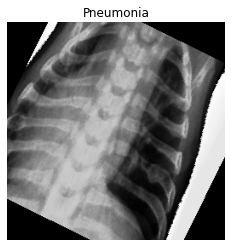

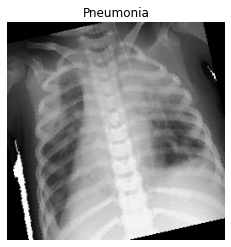

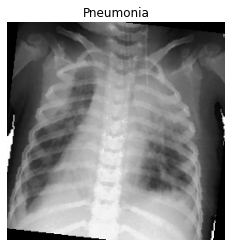

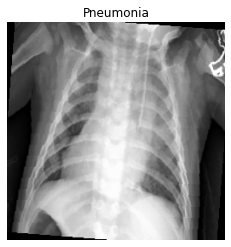

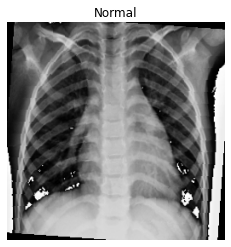

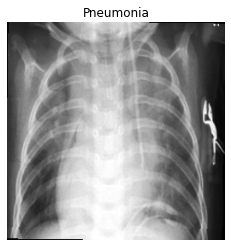

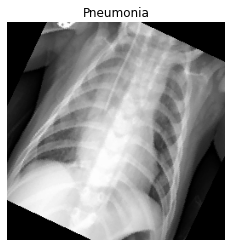

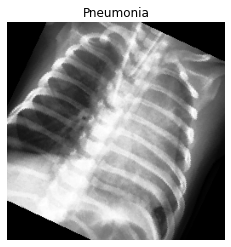

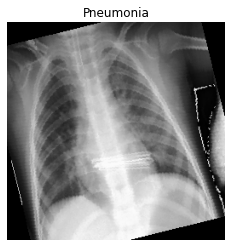

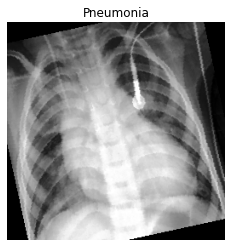

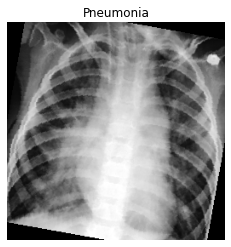

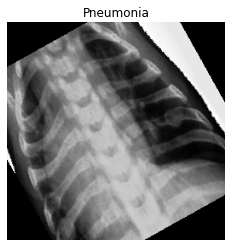

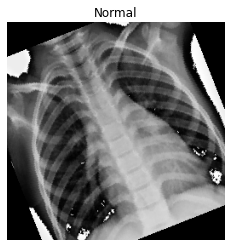

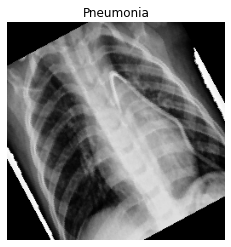

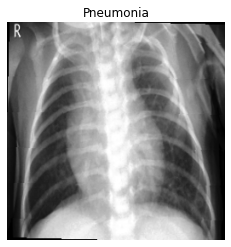

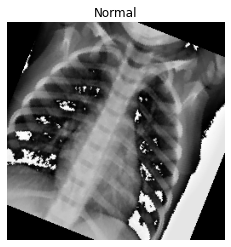

In [91]:
for batch in dataloader:
    
    imgs = batch['img']
    targets = batch['target']
    
    for img, target in zip(imgs, targets):

        target = "Normal" if target == 0 else "Pneumonia"
        # Plot image
        plt.imshow(img[0, :, :], cmap="gray")
        plt.axis('off')
        plt.title(target)
        
        plt.show()